# Soil Fertility & Fertilizer Recommendation Model

This notebook will:
1. **Load** the two provided datasets from `./Data/`.
2. **Visualize** key distributions and correlations in the data.
3. **Engineer** a fertilizer‐recommendation label from nutrient balances.
4. **Preprocess** (encode, select features).
5. **Train** a Random Forest classifier.
6. **Evaluate** performance (accuracy, precision, recall, F1).
7. **Save** the trained model for later virtual simulation / deployment.

---

## 1. Imports & Configuration


In [1]:
# 1. Imports & Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import joblib

# Make plots appear inline
%matplotlib inline

# Set a consistent seaborn style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)


In [3]:
# 2.1 Load the CSV (nutrient balances)
balance_df = pd.read_csv("../Data/Soil nutrient flows/Soil nutrient balance_454 field trials.csv")
print("Balance CSV shape:", balance_df.shape)
print(balance_df.columns.tolist())
balance_df.head(3)
# 2.2 Load the XLS (nutrient inputs/outputs & soil features)
inputs_df = pd.read_excel(
    "../Data/Soil nutrient flows/Soil nutrient inputs_outputs in 454 field trials.xls"
)
print("Inputs XLS shape:", inputs_df.shape)
print(inputs_df.columns.tolist())
inputs_df.head(3)



Balance CSV shape: (454, 6)
['No', 'X', 'Y', 'BalanceN', 'BalanceP', 'BalanceK']
Inputs XLS shape: (454, 56)
['No', 'Text_ID_Fi', 'District', 'Center', 'Latitude', 'Longitude', 'Elevation', 'AEZs_names', 'N_INF', 'P_INF', 'K_INF', 'Crop_inter', 'Yield', 'Citations', 'Erosion', 'Erosion1', 'CEC', 'Clay', 'Bulk_densi', 'MAP', 'Silt', 'TN', 'OC', 'Sand', 'MON', 'Soil_ha', 'OUT1N', 'OUT1P', 'OUT1K', 'OUT2N', 'OUT2P', 'OUT2K', 'IN3N', 'IN3P', 'IN3K', 'IN4N', 'OUT3N', 'OUT3K', 'OUT4N', 'OUT5N', 'OUT5P', 'OUT5K', 'IN1N', 'IN1P', 'IN1K', 'BalanceN', 'BalanceP', 'BalanceK', 'phoshorus(ppm)', 'phoshorus()', 'K(cmol/kg)', 'kg_kgP', 'kg_kg_K', 'P_ha', 'K_ha', 'N_kg_kg']


,No,Text_ID_Fi,District,Center,Latitude,Longitude,Elevation,AEZs_names,N_INF,P_INF,...,BalanceP,BalanceK,phoshorus(ppm),phoshorus(),K(cmol/kg),kg_kgP,kg_kg_K,P_ha,K_ha,N_kg_kg
0,5008,Rwa_Muk_Bean_2015_N,Huye,Mukrua,-2.6779,29.75785,1673,Central Plateau,30,13,...,-4.082871,-32.952642,3.47,347,0.356,0.000003,0.000139,8.4668,339.464526,0.000172
1,5017,Rwa_Muk_Bean_2015_NwP,Huye,Mukrua,-2.6779,29.75785,1673,Central Plateau,30,13,...,-5.868966,-41.782924,3.47,347,0.356,0.000003,0.000139,8.4668,339.464526,0.000172
2,5026,Rwa_Muk_Bean_2015_PwN,Huye,Mukrua,-2.6779,29.75785,1673,Central Plateau,30,13,...,-6.703583,-45.909186,3.47,347,0.356,0.000003,0.000139,8.4668,339.464526,0.000172


In [4]:
# 2.3 Merge datasets on 'No'
df = pd.merge(inputs_df, balance_df[['No', 'BalanceN', 'BalanceP', 'BalanceK']], on="No", how="inner")
print("Merged DataFrame shape:", df.shape)
df.head(3)


Merged DataFrame shape: (454, 59)


,No,Text_ID_Fi,District,Center,Latitude,Longitude,Elevation,AEZs_names,N_INF,P_INF,...,phoshorus(),K(cmol/kg),kg_kgP,kg_kg_K,P_ha,K_ha,N_kg_kg,BalanceN_y,BalanceP_y,BalanceK_y
0,5008,Rwa_Muk_Bean_2015_N,Huye,Mukrua,-2.6779,29.75785,1673,Central Plateau,30,13,...,347,0.356,0.000003,0.000139,8.4668,339.464526,0.000172,-21.212663,13.577129,-36.732642
1,5017,Rwa_Muk_Bean_2015_NwP,Huye,Mukrua,-2.6779,29.75785,1673,Central Plateau,30,13,...,347,0.356,0.000003,0.000139,8.4668,339.464526,0.000172,-31.214894,11.791034,-45.562924
2,5026,Rwa_Muk_Bean_2015_PwN,Huye,Mukrua,-2.6779,29.75785,1673,Central Plateau,30,13,...,347,0.356,0.000003,0.000139,8.4668,339.464526,0.000172,-35.888792,10.956417,-49.689186


['No', 'Text_ID_Fi', 'District', 'Center', 'Latitude', 'Longitude', 'Elevation', 'AEZs_names', 'N_INF', 'P_INF', 'K_INF', 'Crop_inter', 'Yield', 'Citations', 'Erosion', 'Erosion1', 'CEC', 'Clay', 'Bulk_densi', 'MAP', 'Silt', 'TN', 'OC', 'Sand', 'MON', 'Soil_ha', 'OUT1N', 'OUT1P', 'OUT1K', 'OUT2N', 'OUT2P', 'OUT2K', 'IN3N', 'IN3P', 'IN3K', 'IN4N', 'OUT3N', 'OUT3K', 'OUT4N', 'OUT5N', 'OUT5P', 'OUT5K', 'IN1N', 'IN1P', 'IN1K', 'BalanceN_x', 'BalanceP_x', 'BalanceK_x', 'phoshorus(ppm)', 'phoshorus()', 'K(cmol/kg)', 'kg_kgP', 'kg_kg_K', 'P_ha', 'K_ha', 'N_kg_kg', 'BalanceN_y', 'BalanceP_y', 'BalanceK_y']


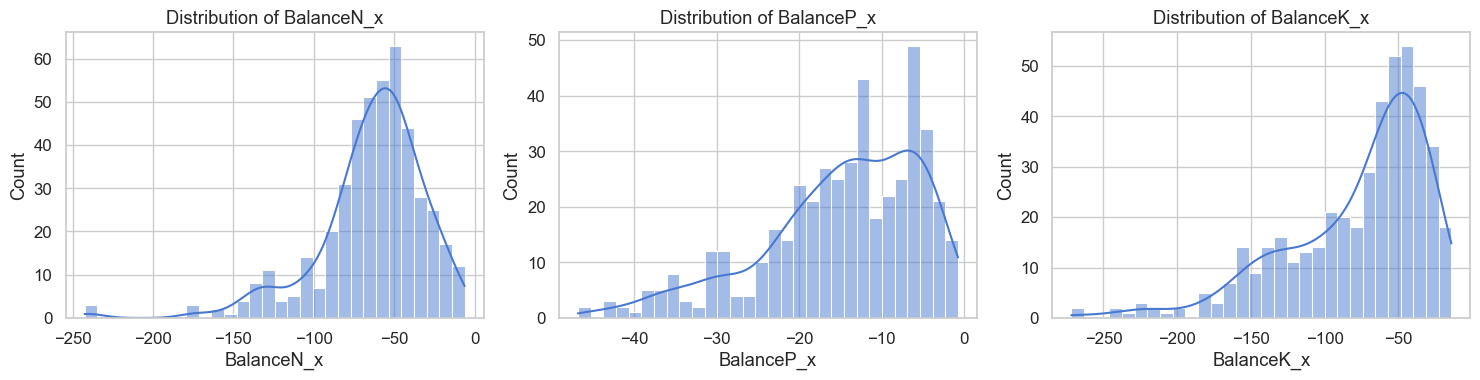

In [6]:
# Check which columns exist
print(df.columns.tolist())

# Use the correct column names for plotting
plt.figure(figsize=(15, 4))
for i, nutrient in enumerate(["BalanceN_x", "BalanceP_x", "BalanceK_x"]):  # or "_y" if you prefer
    plt.subplot(1, 3, i+1)
    sns.histplot(df[nutrient], bins=30, kde=True)
    plt.title(f"Distribution of {nutrient}")
plt.tight_layout()
plt.show()

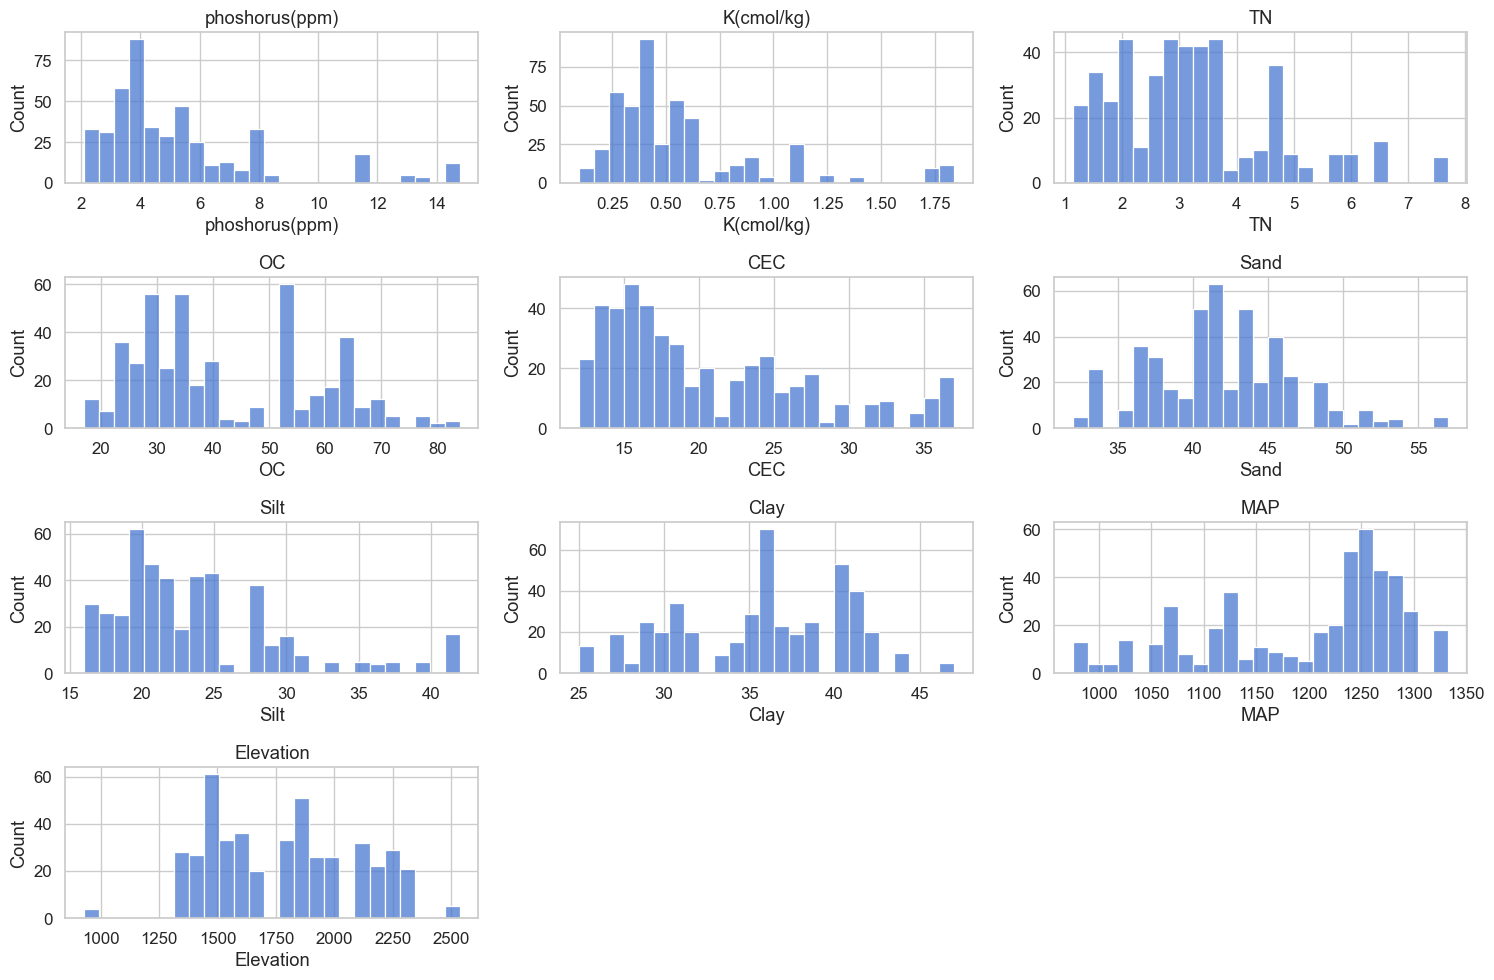

In [7]:
numeric_cols = ["phoshorus(ppm)", "K(cmol/kg)", "TN", "OC", "CEC", "Sand", "Silt", "Clay", "MAP", "Elevation"]
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 3, i+1)
    if col in df.columns:
        sns.histplot(df[col].dropna(), bins=25)
        plt.title(col)
    else:
        plt.text(0.5, 0.5, f"{col} not in DF", ha="center", va="center")
        plt.axis("off")
plt.tight_layout()
plt.show()


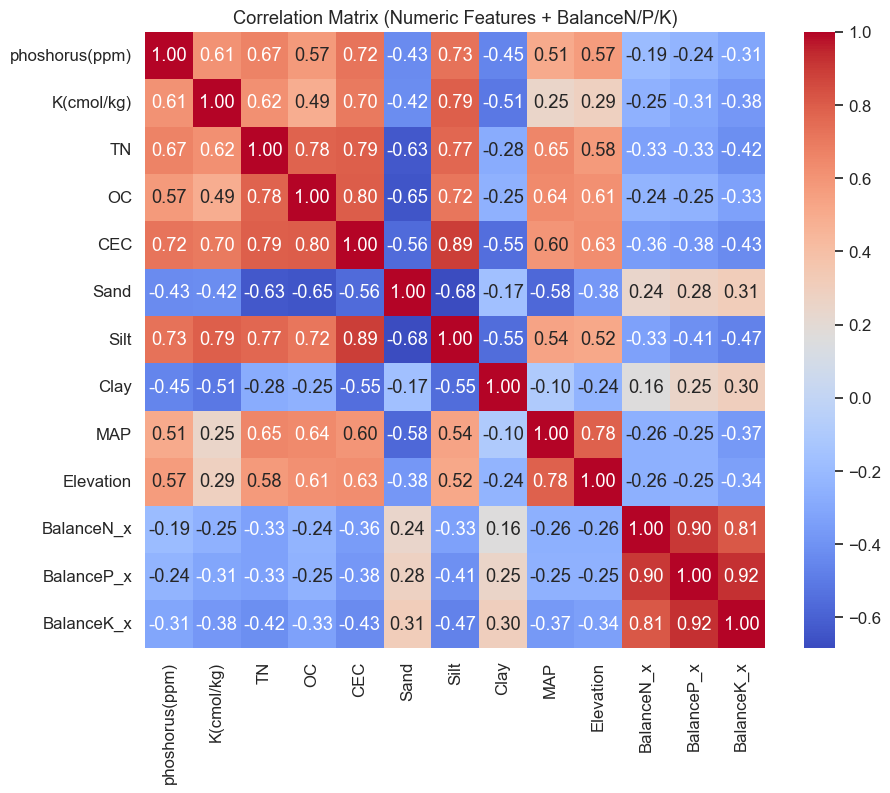

In [9]:
# 3.3 Compute correlation matrix for numeric features
numeric_df = df[numeric_cols + ["BalanceN_x", "BalanceP_x", "BalanceK_x"]].dropna()
corr = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix (Numeric Features + BalanceN/P/K)")
plt.show()

In [11]:
def assign_fertilizer_label(row):
    n_deficit = row["BalanceN_x"] < -10
    p_deficit = row["BalanceP_x"] < -10
    k_deficit = row["BalanceK_x"] < -10
    
    if n_deficit and p_deficit and k_deficit:
        return "Add_NPK_17_17_17"
    elif n_deficit and p_deficit:
        return "Add_DAP"
    elif n_deficit and k_deficit:
        return "Add_NK"
    elif p_deficit and k_deficit:
        return "Add_PK"
    elif n_deficit:
        return "Add_Urea"
    elif p_deficit:
        return "Add_SSP"
    elif k_deficit:
        return "Add_Potash"
    else:
        return "No_Fertilizer_Needed"

df["Fert_Label"] = df.apply(assign_fertilizer_label, axis=1)
print("Value counts for Fert_Label:")
print(df["Fert_Label"].value_counts())

Value counts for Fert_Label:
Fert_Label
Add_NPK_17_17_17    289
Add_NK              159
Add_Potash            6
Name: count, dtype: int64


In [12]:
# 5.1 Define feature columns and target
numeric_features = ["phoshorus(ppm)", "K(cmol/kg)", "TN", "OC", "CEC", "Sand", "Silt", "Clay", "MAP", "Elevation"]
categorical_features = ["Crop_inter"]
target = "Fert_Label"

# 5.2 Subset and drop NaNs
model_df = df[numeric_features + categorical_features + [target]].dropna()
print("After dropping NaNs, shape:", model_df.shape)
model_df.head(3)


After dropping NaNs, shape: (454, 12)


,phoshorus(ppm),K(cmol/kg),TN,OC,CEC,Sand,Silt,Clay,MAP,Elevation,Crop_inter,Fert_Label
0,3.47,0.356,1.72,27,13,41,18,41,1241.630005,1673,Bean,Add_NK
1,3.47,0.356,1.72,27,13,41,18,41,1241.630005,1673,Bean,Add_NK
2,3.47,0.356,1.72,27,13,41,18,41,1241.630005,1673,Bean,Add_NK


In [14]:
# 5.2 One‐hot encode Crop_inter
X_numeric = model_df[numeric_features]
X_categorical = model_df[categorical_features]
y = model_df[target]

# Use sklearn's ColumnTransformer to apply one-hot to Crop_inter
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features)
    ],
    remainder="passthrough"  # keep numeric features as-is
)

# Fit and transform to get final feature matrix
X = preprocessor.fit_transform(model_df[numeric_features + categorical_features])

# Column names after one-hot encoding
onehot_columns = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
all_feature_names = list(onehot_columns) + numeric_features

X_df = pd.DataFrame(X, columns=all_feature_names)
print("Final feature matrix shape:", X_df.shape)
X_df.head(3)


Final feature matrix shape: (454, 20)


,"Crop_inter_Bean, climbing",Crop_inter_Maize,Crop_inter_Pea,"Crop_inter_Potato, Irish","Crop_inter_Potato, sweet","Crop_inter_Rice, lowand","Crop_inter_Rice, lowland",Crop_inter_Sorghum,Crop_inter_Soybean,Crop_inter_Wheat,phoshorus(ppm),K(cmol/kg),TN,OC,CEC,Sand,Silt,Clay,MAP,Elevation
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.47,0.356,1.72,27.0,13.0,41.0,18.0,41.0,1241.630005,1673.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.47,0.356,1.72,27.0,13.0,41.0,18.0,41.0,1241.630005,1673.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.47,0.356,1.72,27.0,13.0,41.0,18.0,41.0,1241.630005,1673.0


In [15]:
# 5.3 Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=42, stratify=y
)
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train label distribution:\n", y_train.value_counts(normalize=True))
print("y_test label distribution:\n", y_test.value_counts(normalize=True))


X_train: (363, 20) X_test: (91, 20)
y_train label distribution:
 Fert_Label
Add_NPK_17_17_17    0.636364
Add_NK              0.349862
Add_Potash          0.013774
Name: proportion, dtype: float64
y_test label distribution:
 Fert_Label
Add_NPK_17_17_17    0.637363
Add_NK              0.351648
Add_Potash          0.010989
Name: proportion, dtype: float64


In [19]:

# 5.4 Oversample "Add_Potash" (and any other tiny classes) with SMOTE
from imblearn.over_sampling import SMOTE

# Check original class counts in y_train
print("Before SMOTE, class distribution in y_train:")
print(y_train.value_counts())

# Configure SMOTE: target only "Add_Potash" up to, say, 30 samples.
# You can adjust 'sampling_strategy' as needed. Here we force Add_Potash → 30.
smote = SMOTE(sampling_strategy={"Add_Potash": 30}, random_state=42, k_neighbors=2)
X_res, y_res = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE, class distribution in y_res:")
print(y_res.value_counts())
print(y_train.value_counts())


Before SMOTE, class distribution in y_train:
Fert_Label
Add_NPK_17_17_17    231
Add_NK              127
Add_Potash            5
Name: count, dtype: int64

After SMOTE, class distribution in y_res:
Fert_Label
Add_NPK_17_17_17    231
Add_NK              127
Add_Potash           30
Name: count, dtype: int64
Fert_Label
Add_NPK_17_17_17    231
Add_NK              127
Add_Potash            5
Name: count, dtype: int64


In [20]:
# 6.1 Instantiate & Train Random Forest
# 6.1 Instantiate & Train Random Forest (with class weights) on resampled set
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",   # still helpful if other minor imbalances exist
    random_state=42
)

rf_clf.fit(X_res, y_res)


RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

Classification Report:

                  precision    recall  f1-score   support

          Add_NK       0.75      0.75      0.75        32
Add_NPK_17_17_17       0.93      0.88      0.90        58
      Add_Potash       0.00      0.00      0.00         1

        accuracy                           0.82        91
       macro avg       0.56      0.54      0.55        91
    weighted avg       0.85      0.82      0.84        91



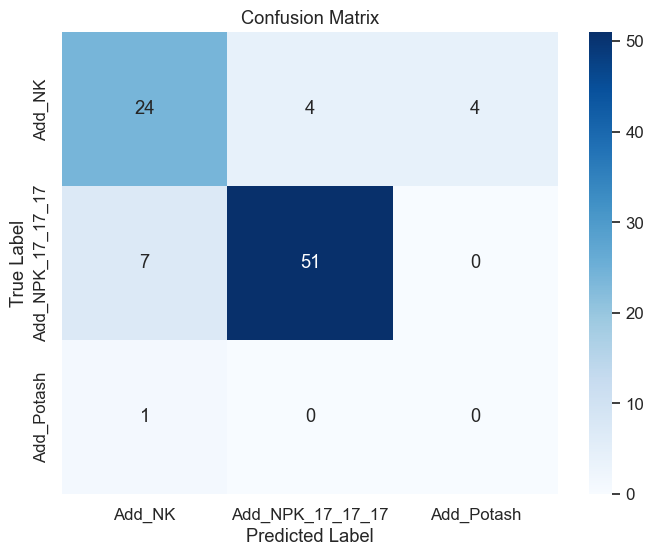

In [22]:
# 7.1 Predictions on Test Set
y_pred = rf_clf.predict(X_test)

# 7.2 Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# 7.3 Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=rf_clf.classes_, 
            yticklabels=rf_clf.classes_,
            cmap="Blues")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()


===== Stratified 5-Fold CV Results =====
                  precision    recall  f1-score   support

          Add_NK     0.7987    0.7484    0.7727       159
Add_NPK_17_17_17     0.8973    0.9066    0.9019       289
      Add_Potash     0.2308    0.5000    0.3158         6

        accuracy                         0.8458       454
       macro avg     0.6422    0.7183    0.6635       454
    weighted avg     0.8539    0.8458    0.8489       454



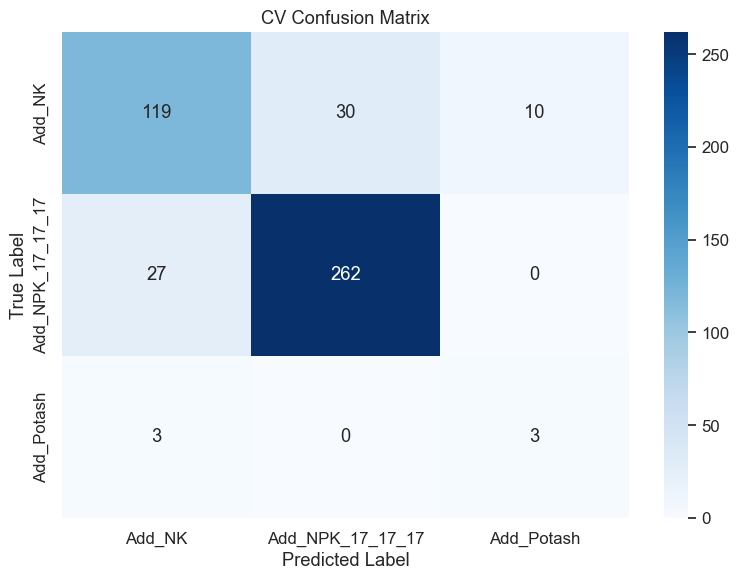

In [34]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

from imblearn.combine import SMOTETomek

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

pipe = ImbPipeline(steps=[
    ("smotetomek", SMOTETomek(
        smote=SMOTE(sampling_strategy={"Add_Potash": 30}, random_state=42, k_neighbors=2),
        sampling_strategy={"Add_Potash": 30},
        random_state=42
    )),
    ("rf", RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        class_weight="balanced",
        random_state=42
    ))
])

# 1.2 Prepare StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1.3 cross_val_predict to get out‐of‐fold predictions
y_oof = cross_val_predict(pipe, X_df, y, cv=skf, n_jobs=-1)

# 1.4 Show classification report on those OOF predictions
print("===== Stratified 5-Fold CV Results =====")
print(classification_report(y, y_oof, digits=4))

# 1.5 Optional: Show overall confusion matrix
cm = confusion_matrix(y, y_oof, labels=np.unique(y))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=np.unique(y),
            yticklabels=np.unique(y),
            cmap="Blues")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("CV Confusion Matrix")
plt.tight_layout()
plt.show()



C:\Users\twemb\AppData\Local\Temp\ipykernel_32036\4207773049.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_imp_df.head(15), palette="viridis")


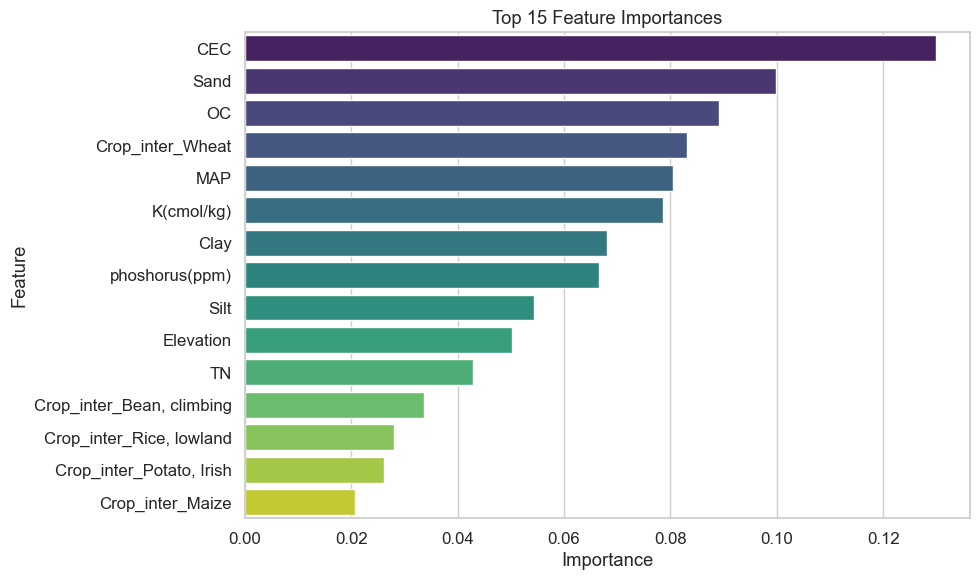

In [35]:
# 8.1 Get feature importances from trained Random Forest
importances = rf_clf.feature_importances_
feat_imp_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feat_imp_df.head(15), palette="viridis")
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [38]:
# 9.1 Save preprocessor & model to disk
joblib.dump(preprocessor, "soil_fertility_preprocessor.joblib")
joblib.dump(rf_clf, "soil_fertility_rf_model.joblib")

print("Preprocessor and model saved successfully.")


Preprocessor and model saved successfully.


In [44]:
import pandas as pd
import joblib

# 1. Load saved objects
preprocessor = joblib.load("soil_fertility_preprocessor.joblib")
model = joblib.load("soil_fertility_rf_model.joblib")

# 2. Default rates mapping (ensure this is defined or loaded somewhere above)
default_rates = {
    "Add_Urea": 40,
    "Add_SSP": 170,
    "Add_Potash": 16,
    "Add_NK": 50,
    "Add_DAP": 100,
    "Add_NPK_17_17_17": 120,
    "No_Fertilizer_Needed": 0
}

# 3. New sample dictionary (farmer’s soil + chosen crop)
new_sample = {
    "phoshorus(ppm)": 8.5,
    "K(cmol/kg)": 0.15,
    "TN": 0.12,
    "OC": 1.8,
    "CEC": 15,
    "Sand": 40,
    "Silt": 45,
    "Clay": 15,
    "MAP": 1200,
    "Elevation": 1600,
    "Crop_inter": "Maize"
}

# 4. Convert to DataFrame
new_df = pd.DataFrame([new_sample])

# 5. Preprocess and predict
X_new = preprocessor.transform(new_df)
pred_label = model.predict(X_new)[0]

# 6. Lookup default application rate
recommended_rate = default_rates[pred_label]


print(f"Recommended Fertilizer for {new_sample['Crop_inter']} is: {pred_label}")
print(f"Apply {recommended_rate} kg/ha")


Recommended Fertilizer for Maize is: Add_NPK_17_17_17
Apply 120 kg/ha


C:\Users\twemb\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
